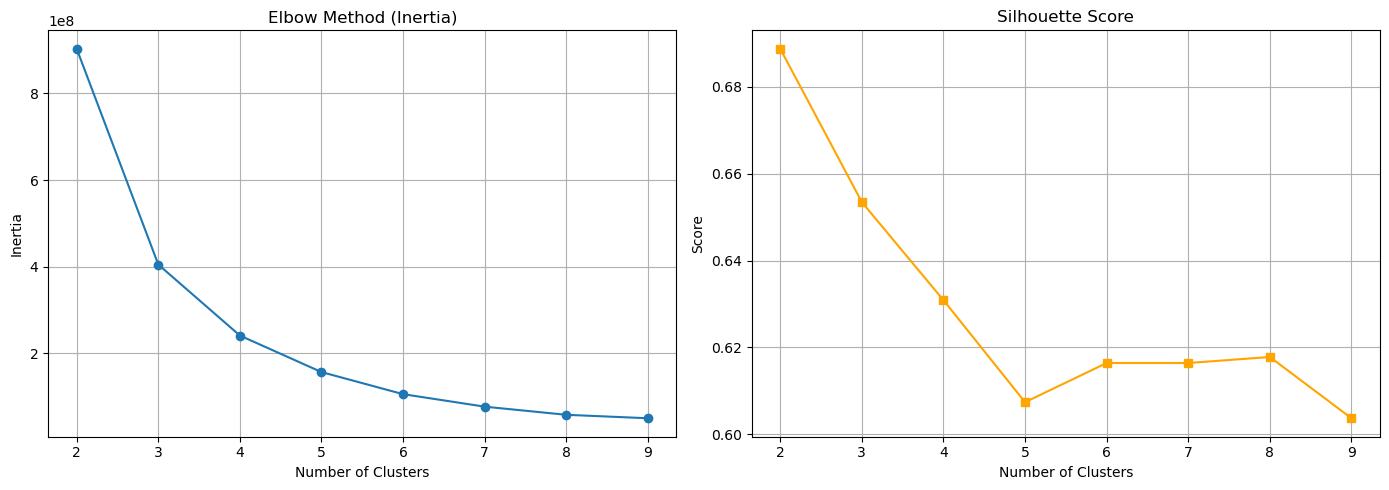

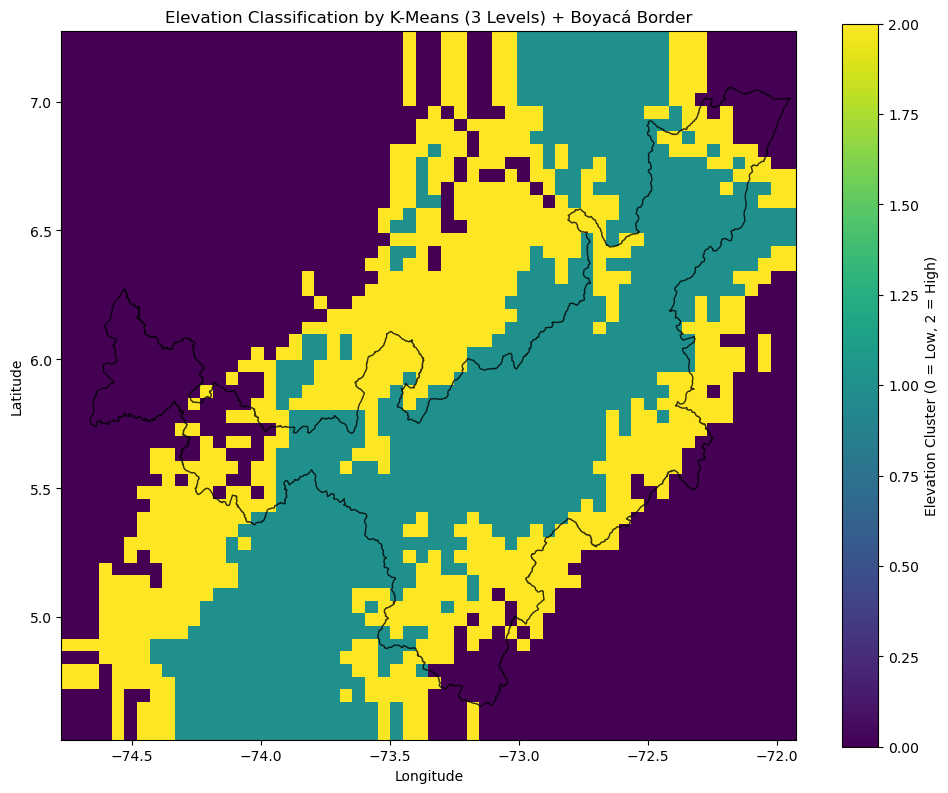

,min,max,mean,std
Elevation Category,,,,
Level 1,69.0,969.0,355.61,246.82
Level 3,2285.0,4728.0,2976.92,459.43
Level 2,978.0,2283.0,1599.04,375.98


In [1]:
# =================== LIBRERÍAS ===================
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import geopandas as gpd
import pandas as pd

# =================== CARGAR DATASET ===================
ds = xr.open_dataset("/Users/riperez/Conda/anaconda3/doc/precipitation/output/boyaca_region_months_aggregated_avg_merged_dem.nc") 

# =================== EXTRAER DEM ===================
dem = ds["DEM"]
if "month_index" in dem.dims:
    dem_2d = dem.sel(month_index=1)
else:
    dem_2d = dem

dem_values = dem_2d.values
flat_dem = dem_values.flatten()
flat_valid = flat_dem[~np.isnan(flat_dem)].reshape(-1, 1)

# =================== GRÁFICO DEL CODO ===================
inertias = []
silhouettes = []
k_range = range(2, 10)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(flat_valid)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(flat_valid, km.labels_))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, marker='s', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# =================== APLICAR K-MEANS CON 3 CLUSTERS ===================
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(flat_valid)

# Crear una matriz de etiquetas con la misma forma que DEM
labels_map = np.full_like(dem_values, np.nan)
labels_flat = np.full(flat_dem.shape, np.nan)
labels_flat[~np.isnan(flat_dem)] = kmeans.labels_
labels_map = labels_flat.reshape(dem_values.shape)

# =================== CARGAR SHAPEFILE Y FILTRAR BOYACÁ ===================
shp_path = "/Users/riperez/Conda/anaconda3/doc/precipitation/shapes/MGN_Departamento.shp"
gdf = gpd.read_file(shp_path)

# Filtrar geometrías válidas (Boyacá se espera esté entre ellas)
gdf_boyaca = gdf[gdf["geometry"].notnull()]

# =================== VISUALIZACIÓN CON LÍMITES DEPARTAMENTALES ===================
plt.figure(figsize=(10, 8))

# Mapa de clasificación de elevación
c = plt.imshow(labels_map, origin='lower', cmap='viridis', extent=[
    ds.longitude.min(), ds.longitude.max(), ds.latitude.min(), ds.latitude.max()
])

# Añadir límites de Boyacá
gdf_boyaca.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1.0, alpha=0.8)

# Colorbar y detalles
plt.colorbar(c, label="Elevation Cluster (0 = Low, 2 = High)")
plt.title("Elevation Classification by K-Means (3 Levels) + Boyacá Border")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

# =================== RANGOS DE CATEGORÍAS ===================
# Obtener centroides y convertirlos en rangos
centroids = kmeans.cluster_centers_.flatten()
sorted_idx = np.argsort(centroids)
categories = {i: f"Level {rank+1}" for rank, i in enumerate(sorted_idx)}

# Rango de elevación por categoría
ranges = {}
for i in range(n_clusters):
    elev_values = flat_valid[kmeans.labels_ == i]
    ranges[categories[i]] = {
        "min": round(elev_values.min(), 2),
        "max": round(elev_values.max(), 2),
        "mean": round(elev_values.mean(), 2),
        "std": round(elev_values.std(), 2)
    }

df_ranges = pd.DataFrame(ranges).T
df_ranges.index.name = "Elevation Category"
display(df_ranges)



,Low Elevation,Medium Elevation,High Elevation
1-Jan,63.643631,64.309494,40.405220
2-Feb,87.272942,90.092812,54.009953
3-Mar,154.756760,140.601578,87.568092
4-Apr,286.077362,235.464630,157.562073
5-May,337.563263,256.508057,157.435287
6-Jun,278.866241,205.718552,136.138687
7-Jul,254.674042,192.062592,126.632904
8-Aug,263.746429,185.527649,111.449600
9-Sep,284.835449,193.661591,115.434502
10-Oct,330.882599,251.276733,158.722443


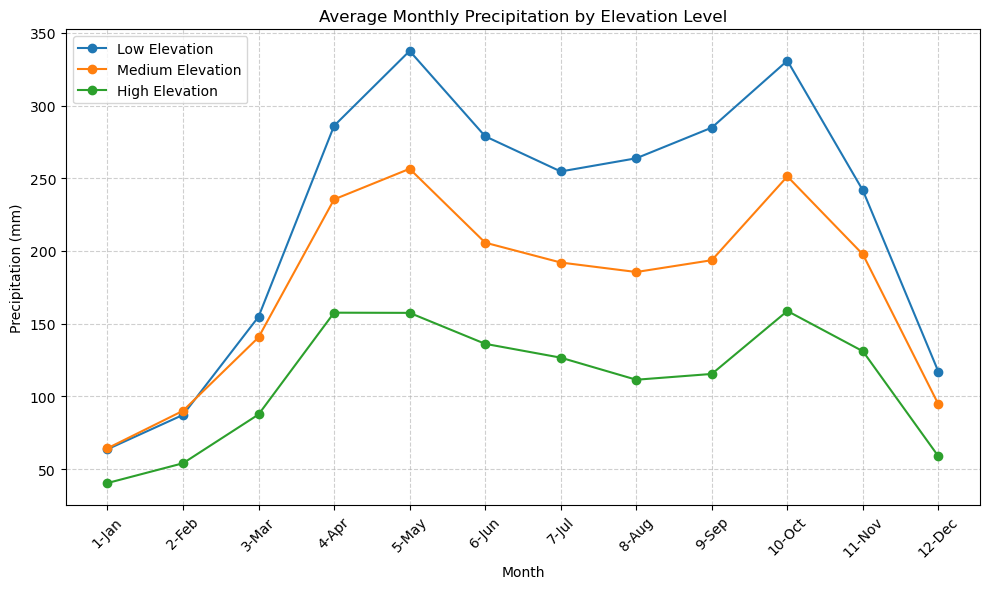

In [2]:
# =================== CÁLCULO DE PROMEDIOS POR CLUSTER ===================

# 1. Convertir labels de elevación en enteros (0, 1, 2) → mapeados a categoría
labels_by_rank = {rank: cluster for rank, cluster in enumerate(sorted_idx)}  # Level 0, 1, 2
rank_labels_map = np.full_like(labels_map, np.nan)
for rank, cluster in labels_by_rank.items():
    rank_labels_map[labels_map == cluster] = rank  # rank 0=baja, 1=media, 2=alta

# 2. Inicializar estructura para guardar promedios
monthly_means = {0: [], 1: [], 2: []}  # 0 = baja, 1 = media, 2 = alta

# 3. Loop mensual
for month in range(1, 13):
    precip_2d = ds["mean_precipitation"].sel(month_index=month).values

    for rank in [0, 1, 2]:
        mask = (rank_labels_map == rank) & ~np.isnan(precip_2d)
        mean_value = np.nanmean(precip_2d[mask])
        monthly_means[rank].append(mean_value)

# 4. Crear índice tipo "1-Jan", ..., "12-Dec"
month_labels = [f"{i}-{name}" for i, name in enumerate([
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
], start=1)]

# 5. Convertir a DataFrame
df_precip_by_elev = pd.DataFrame(monthly_means)
df_precip_by_elev.columns = ["Low Elevation", "Medium Elevation", "High Elevation"]
df_precip_by_elev.index = month_labels

# 6. Mostrar tabla
display(df_precip_by_elev)

# 7. Graficar
plt.figure(figsize=(10, 6))
for col in df_precip_by_elev.columns:
    plt.plot(df_precip_by_elev.index, df_precip_by_elev[col], marker='o', label=col)

plt.title("Average Monthly Precipitation by Elevation Level")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



✅ Proceso finalizado con éxito!


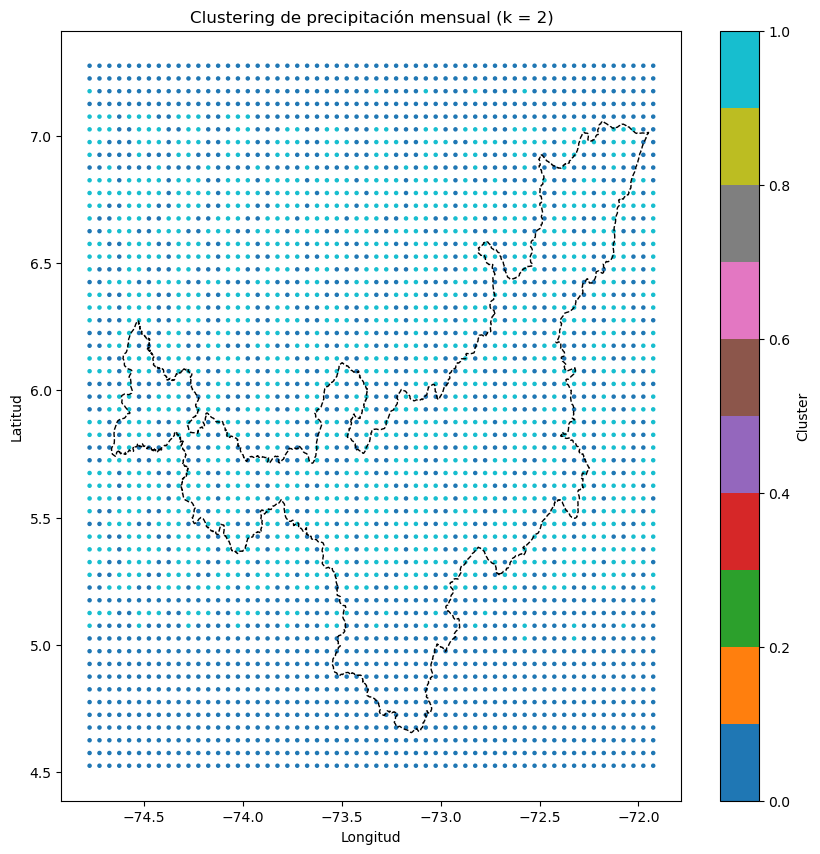

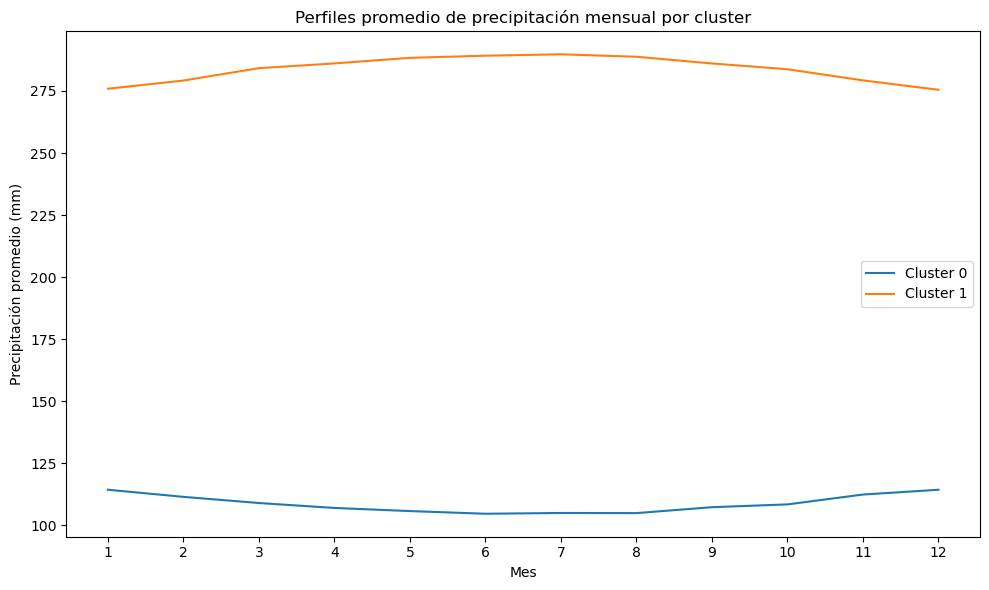

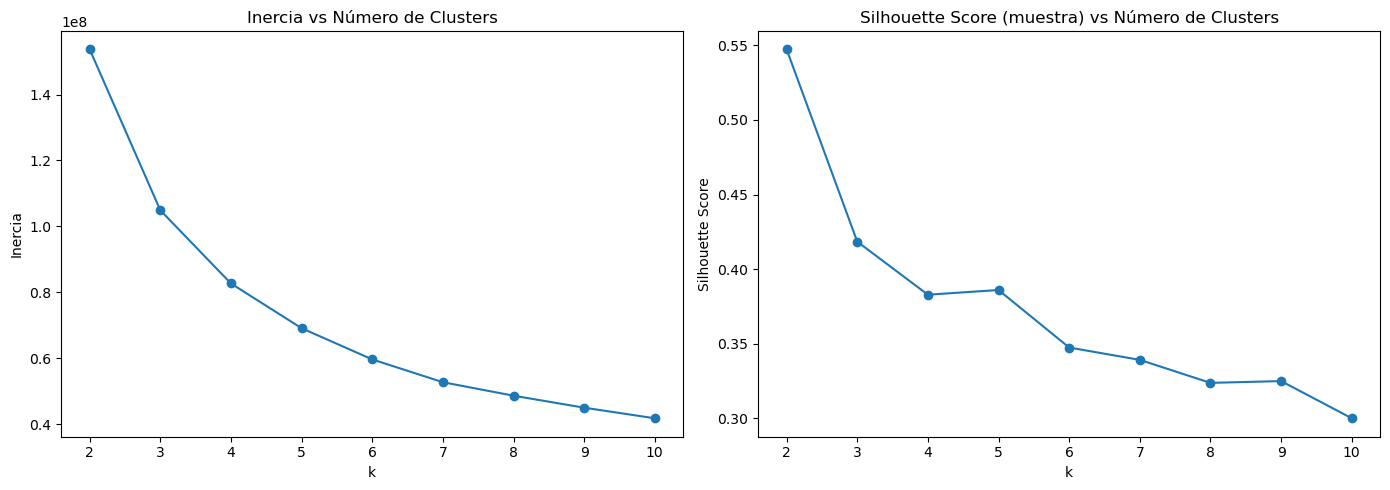

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import shape, Point, Polygon, MultiPolygon
import fiona
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# === Paso 1: Definir "month_array" ===
# Suponiendo que tienes un dataset con datos mensuales de precipitación
# Aquí se convierte en un array NumPy para clustering
import xarray as xr

# Ruta al archivo NetCDF
file_path = "/Users/riperez/Conda/anaconda3/doc/precipitation/output/boyaca_region_monthly_sum.nc"
ds = xr.open_dataset(file_path)

# Extraer datos mensuales de precipitación
precip_data = ds["total_precipitation"]
month_array = precip_data.groupby("time.month").mean(dim="time").values

# Reshape the array to 2D if it has more than 2 dimensions
if month_array.ndim > 2:
    month_array = month_array.reshape(month_array.shape[0], -1)

# Ensure the number of rows in 'month_array' matches the number of coordinates
if month_array.shape[0] != precip_data.shape[1] * precip_data.shape[2]:
    month_array = month_array.reshape(precip_data.shape[1] * precip_data.shape[2], -1)

# === Paso 1: Evaluar k óptimo ===
inertias = []
silhouettes = []
ks = range(2, 11)

for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(month_array)
    sample_indices = np.random.choice(len(month_array), size=min(1000, len(month_array)), replace=False)
    silhouettes.append(silhouette_score(month_array[sample_indices], labels[sample_indices]))
    inertias.append(model.inertia_)

# === Paso 2: Ajustar modelo con k óptimo ===
optimal_k = ks[np.argmax(silhouettes)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(month_array)

# === Paso 3: Preparar DataFrame con resultados ===
# Definir latitudes y longitudes
latitudes = ds["latitude"].values.flatten()
longitudes = ds["longitude"].values.flatten()

# Crear un array de coordenadas
coords_array = np.array([(lat, lon) for lat in latitudes for lon in longitudes])

# Ensure the number of coordinates matches the reshaped 'month_array'
if len(coords_array) != month_array.shape[0]:
    coords_array = coords_array[:month_array.shape[0]]

# Crear un array de coordenadas
coords_array = np.array([(lat, lon) for lat in latitudes for lon in longitudes])

# Asegurarse de que el número de filas coincida con el número de etiquetas
if month_array.shape[0] != len(coords_array):
    raise ValueError("El número de filas en 'month_array' no coincide con el número de coordenadas.")

# Ajustar el número de etiquetas para que coincida con las coordenadas
labels = labels[:len(coords_array)]

# Crear el DataFrame
df = pd.DataFrame(coords_array, columns=["latitude", "longitude"])
df["cluster"] = labels

# === Paso 4: Cargar geometría de Boyacá con Fiona ===
shp_path = "/Users/riperez/Conda/anaconda3/doc/precipitation/shapes/MGN_Departamento.shp"
boyaca_geoms = []
with fiona.open(shp_path, "r") as src:
    for feat in src:
        geom = shape(feat["geometry"])
        if isinstance(geom, Polygon):
            boyaca_geoms.append(geom)
        elif isinstance(geom, MultiPolygon):
            boyaca_geoms.extend(geom.geoms)

# === Paso 5: Mapa de clusters ===
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(df["longitude"], df["latitude"], c=df["cluster"], cmap="tab10", s=5)
for geom in boyaca_geoms:
    x, y = geom.exterior.xy
    ax.plot(x, y, color="black", linestyle="--", linewidth=1)

ax.set_title(f"Clustering de precipitación mensual (k = {optimal_k})")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
plt.colorbar(scatter, ax=ax, label="Cluster")
fig.savefig("/Users/riperez/Conda/anaconda3/doc/precipitation/output/mapa_clusters_boyaca.png", dpi=300)

# === Paso 6: Curvas promedio por cluster ===
fig2, ax2 = plt.subplots(figsize=(10, 6))
for i in range(optimal_k):
    cluster_series = month_array[labels == i]
    mean_profile = cluster_series.mean(axis=0)
    ax2.plot(range(1, 13), mean_profile, label=f"Cluster {i}")
ax2.set_xticks(range(1, 13))
ax2.set_xlabel("Mes")
ax2.set_ylabel("Precipitación promedio (mm)")
ax2.set_title("Perfiles promedio de precipitación mensual por cluster")
ax2.legend()
fig2.tight_layout()
fig2.savefig("/Users/riperez/Conda/anaconda3/doc/precipitation/output/perfiles_clusters_boyaca.png", dpi=300)

# === Paso 7: Gráficas de evaluación de k ===
fig3, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 5))
ax3.plot(ks, inertias, marker='o')
ax3.set_title("Inercia vs Número de Clusters")
ax3.set_xlabel("k")
ax3.set_ylabel("Inercia")

ax4.plot(ks, silhouettes, marker='o')
ax4.set_title("Silhouette Score (muestra) vs Número de Clusters")
ax4.set_xlabel("k")
ax4.set_ylabel("Silhouette Score")

fig3.tight_layout()
fig3.savefig("/Users/riperez/Conda/anaconda3/doc/precipitation/output/k_selection_metrics.png", dpi=300)

# Rutas exportadas
"/Users/riperez/Conda/anaconda3/doc/precipitation/output/mapa_clusters_boyaca.png", "/Users/riperez/Conda/anaconda3/doc/precipitation/output/perfiles_clusters_boyaca.png", "/Users/riperez/Conda/anaconda3/doc/precipitation/output/k_selection_metrics.png"
print("✅ Proceso finalizado con éxito!")

/var/folders/83/c6n8lktn4qx_fwp7ksllkkhn0dhtn2/T/ipykernel_62559/235656917.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.91, 0.97])


('/Users/riperez/Conda/anaconda3/doc/precipitation/output/clusters_mensuales_boyaca_colormap.png',
 '/Users/riperez/Conda/anaconda3/doc/precipitation/output/k_selection_por_mes.png')

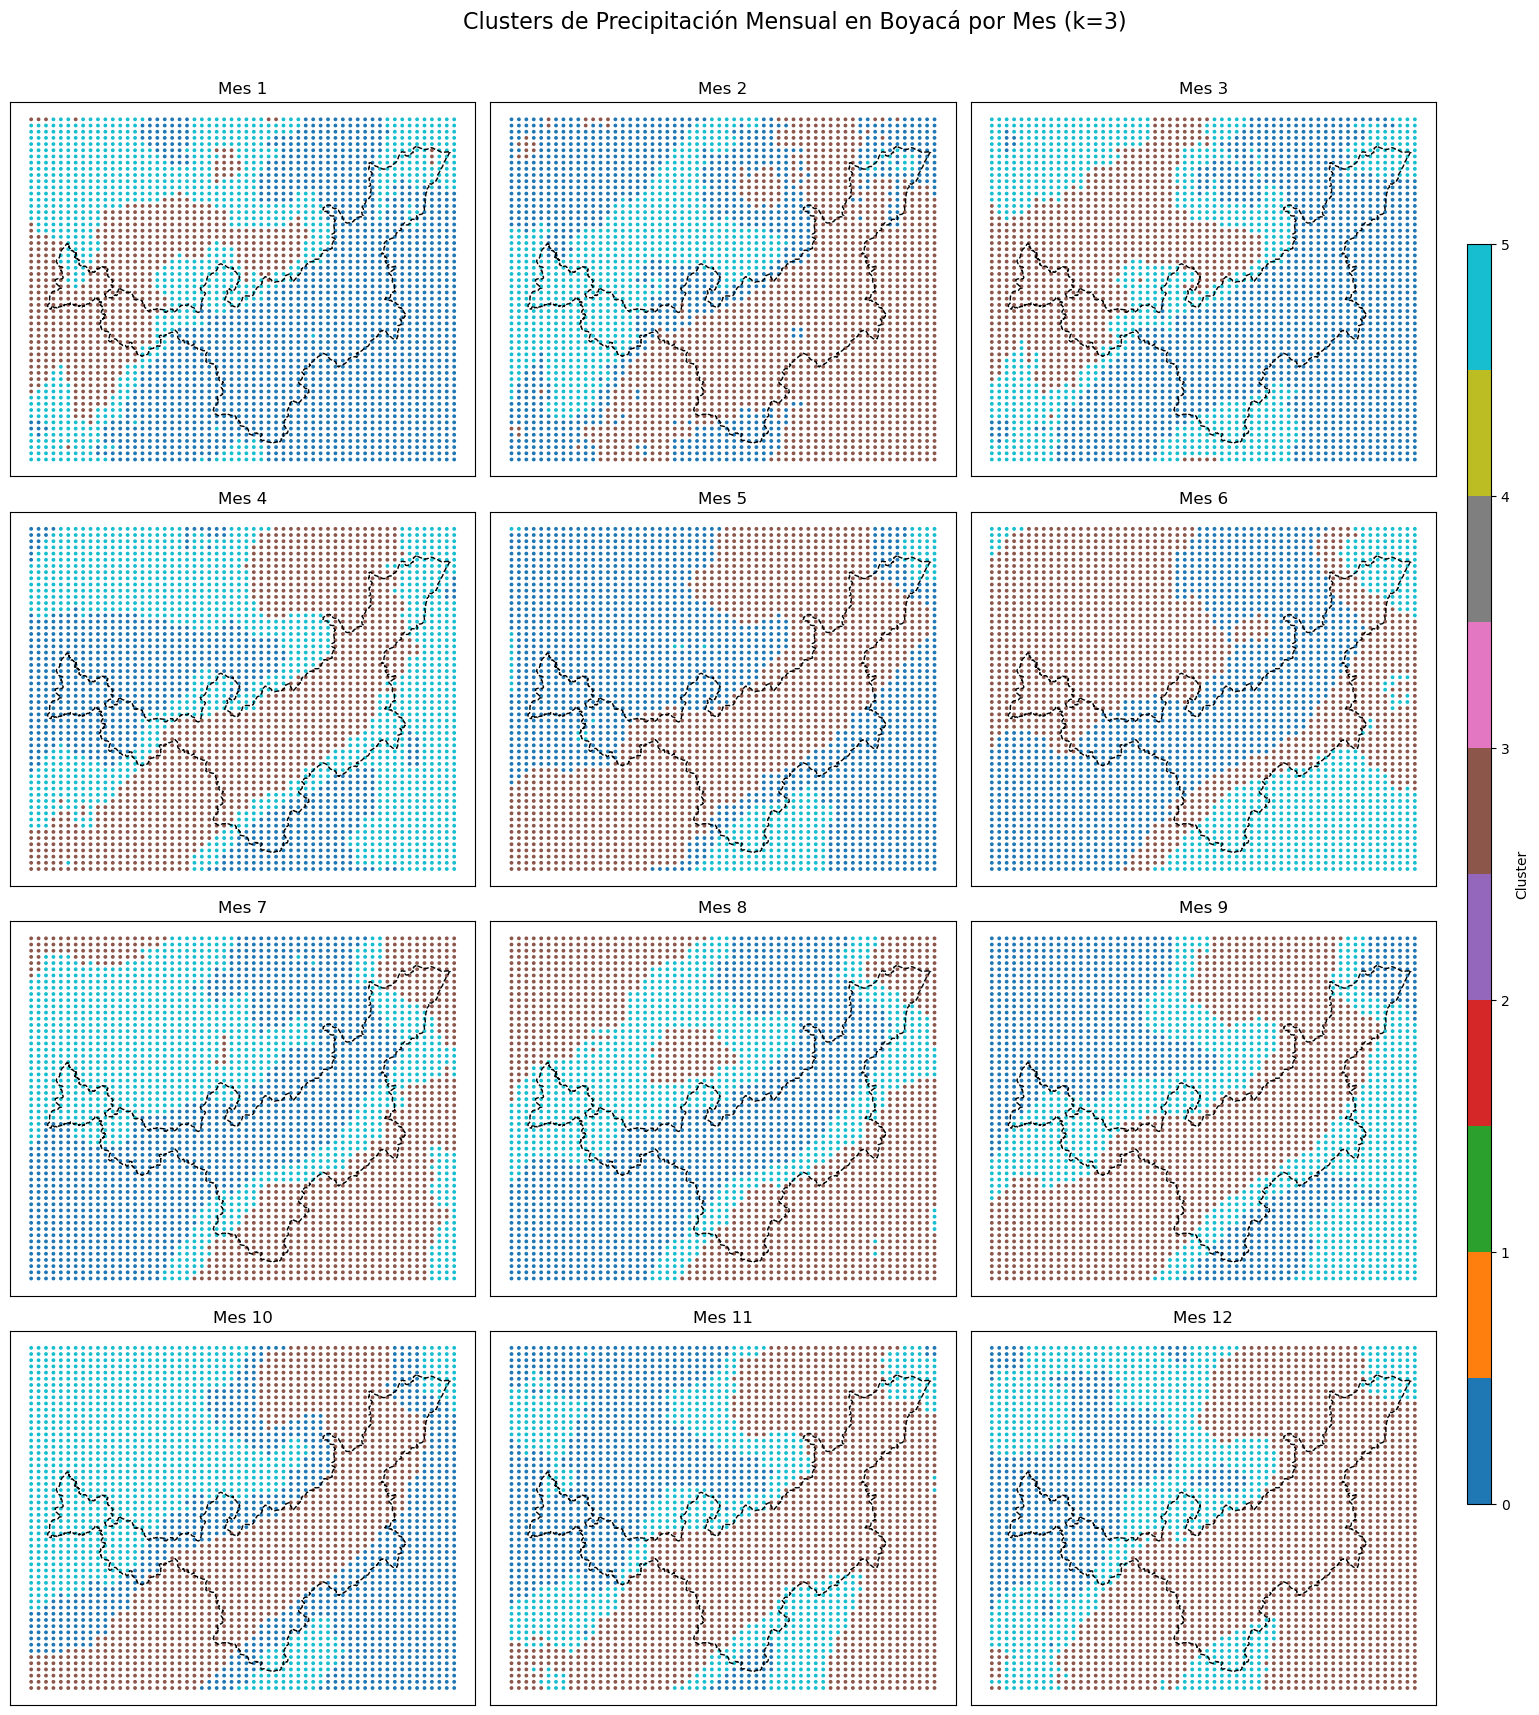

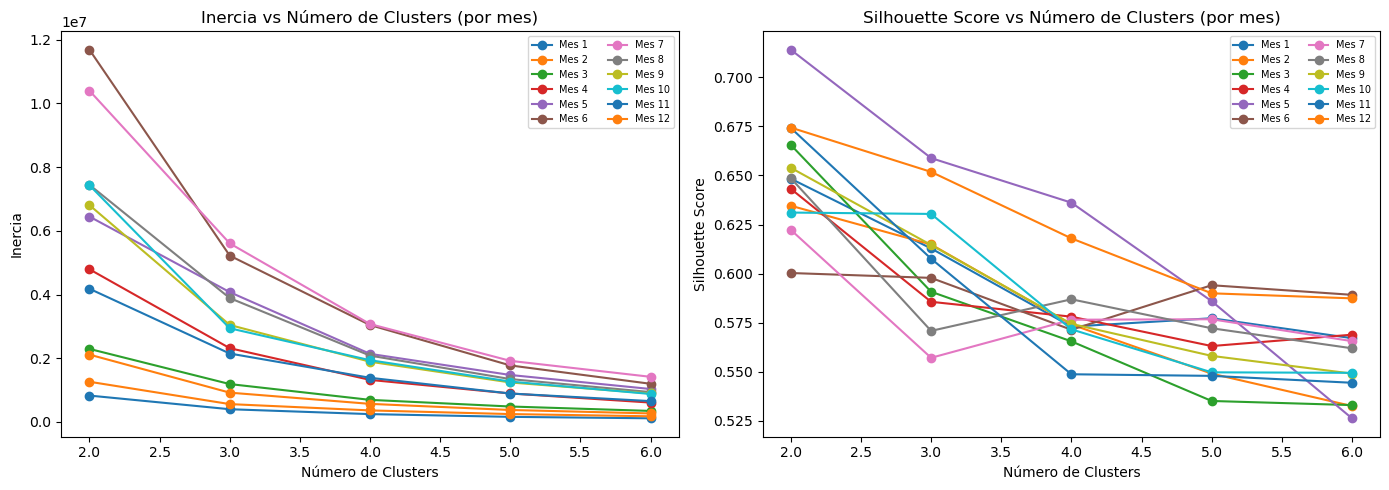

In [4]:
# Reimportar dependencias tras reset del entorno
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from shapely.geometry import shape, Polygon, MultiPolygon
import fiona
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# === Cargar datos ===
ds = xr.open_dataset("/Users/riperez/Conda/anaconda3/doc/precipitation/output/boyaca_region_monthly_sum.nc")
precip = ds["total_precipitation"]
latitudes = ds["latitude"].values
longitudes = ds["longitude"].values
coords = [(lat, lon) for lat in latitudes for lon in longitudes]

# === Cargar shapefile con Fiona ===
shp_path = "/Users/riperez/Conda/anaconda3/doc/precipitation/shapes/MGN_Departamento.shp"
boyaca_geoms = []
with fiona.open(shp_path, "r") as src:
    for feat in src:
        geom = shape(feat["geometry"])
        if isinstance(geom, Polygon):
            boyaca_geoms.append(geom)
        elif isinstance(geom, MultiPolygon):
            boyaca_geoms.extend(geom.geoms)

# === Evaluación de k mensual ===
ks = list(range(2, 7))
monthly_k_selection = {month: {"inertia": [], "silhouette": []} for month in range(1, 13)}

# === Crear figura de clusters mensuales ===
fig, axes = plt.subplots(4, 3, figsize=(16, 18))
norm = Normalize(vmin=0, vmax=5)
cmap = plt.get_cmap("tab10")

for month_idx in range(1, 13):
    precip_month = precip.sel(time=precip['time.month'] == month_idx)
    mean_precip = precip_month.mean(dim="time")
    precip_array = mean_precip.values.reshape(-1, 1)
    valid_mask = ~np.isnan(precip_array).flatten()
    data_valid = precip_array[valid_mask]

    best_k = 3
    labels = np.full_like(precip_array.flatten(), fill_value=np.nan, dtype=float)

    for k in ks:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        lbls = model.fit_predict(data_valid)
        inertia = model.inertia_
        silhouette = silhouette_score(data_valid, lbls)
        monthly_k_selection[month_idx]["inertia"].append(inertia)
        monthly_k_selection[month_idx]["silhouette"].append(silhouette)
        if k == best_k:
            labels[valid_mask] = lbls

    df = pd.DataFrame([coords[i] for i in range(len(coords)) if i < len(labels)],
                      columns=["latitude", "longitude"])
    df["cluster"] = labels

    ax = axes[(month_idx - 1) // 3, (month_idx - 1) % 3]
    scatter = ax.scatter(df["longitude"], df["latitude"], c=df["cluster"], cmap=cmap, s=3)
    for geom in boyaca_geoms:
        x, y = geom.exterior.xy
        ax.plot(x, y, color="black", linestyle="--", linewidth=1)
    ax.set_title(f"Mes {month_idx}")
    ax.set_xticks([])
    ax.set_yticks([])

# === Barra de colores global ===
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=range(6))
cbar.set_label("Cluster")

fig.suptitle("Clusters de Precipitación Mensual en Boyacá por Mes (k=3)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 0.91, 0.97])
fig.savefig("/Users/riperez/Conda/anaconda3/doc/precipitation/output/clusters_mensuales_boyaca_colormap.png", dpi=120)

# === Gráficas de evaluación de k por mes ===
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for month_idx in range(1, 13):
    inertia = monthly_k_selection[month_idx]["inertia"]
    silhouette = monthly_k_selection[month_idx]["silhouette"]
    ax1.plot(ks, inertia, marker='o', label=f"Mes {month_idx}")
    ax2.plot(ks, silhouette, marker='o', label=f"Mes {month_idx}")

ax1.set_title("Inercia vs Número de Clusters (por mes)")
ax1.set_xlabel("Número de Clusters")
ax1.set_ylabel("Inercia")
ax2.set_title("Silhouette Score vs Número de Clusters (por mes)")
ax2.set_xlabel("Número de Clusters")
ax2.set_ylabel("Silhouette Score")
ax1.legend(ncol=2, fontsize=7, loc='upper right')
ax2.legend(ncol=2, fontsize=7, loc='upper right')

plt.tight_layout()
fig2.savefig("/Users/riperez/Conda/anaconda3/doc/precipitation/output/k_selection_por_mes.png", dpi=150)

"/Users/riperez/Conda/anaconda3/doc/precipitation/output/clusters_mensuales_boyaca_colormap.png", "/Users/riperez/Conda/anaconda3/doc/precipitation/output/k_selection_por_mes.png"
